In [1]:
#import csv files
matplotliv notebook
from matplotlib import style
import matplotlib.pyplot as plt

import os
import pandas as pd
import csv
import matplotlib as plt
import datetime as dt
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from sqlalchemy.orm import sessionmaker



# Define start/end variables
startDate = dt.date(2016,11,21)
endDate = dt.date(2016,11,30)


cln_HImeasCSVpath = os.path.join("Resources", "clean_hawaii_measurements.csv")
cln_HIstationCSVpath= os.path.join("Resources", "clean_hawaii_stations.csv")

measurementsDF = pd.read_csv(cln_HImeasCSVpath)
measurementsDF = measurementsDF.drop('Unnamed: 0', axis = 1)
stationsDF = pd.read_csv(cln_HIstationCSVpath)
stationsDF = stationsDF.drop('Unnamed: 0', axis = 1)
stationsDF['name'] = stationsDF['name'].str.rstrip(', HI US')


measurementsDF.head()

,station,date,prcp,tobs
0,USC00519397,1/1/2010,0.08,65
1,USC00513117,1/1/2010,0.28,67
2,USC00518838,1/1/2010,0.21,72
3,USC00519523,1/1/2010,0.15,75
4,USC00519281,1/1/2010,0.15,70


In [44]:
stationsDF.head(20)

,station,name,latitude,longitude,elevation
0,USC00519397,WAIKIKI 717.2,21.27160,-157.81680,3.0
1,USC00513117,KANEOHE 838.1,21.42340,-157.80150,14.6
2,USC00514830,KUALOA RANCH HEADQUARTERS 886.9,21.52130,-157.83740,7.0
3,USC00517948,PEARL CITY,21.39340,-157.97510,11.9
4,USC00518838,UPPER WAHIAWA 874.3,21.49920,-158.01110,306.6
5,USC00519523,WAIMANALO EXPERIMENTAL FARM,21.33556,-157.71139,19.5
6,USC00519281,WAIHEE 837.5,21.45167,-157.84889,32.9
7,USC00511918,HONOLULU OBSERVATORY 702.2,21.31520,-157.99920,0.9
8,USC00516128,MANOA LYON ARBO 785.2,21.33310,-157.80250,152.4


In [3]:
print(f'measurementsDF shape: {measurementsDF.shape}')
print(f'stationsDF shape: {stationsDF.shape}')

measurementsDF shape: (18103, 4)
stationsDF shape: (9, 5)


In [14]:
# Use 3 slashes when connecting to sqlite database
path_to_file = os.path.join("Resources", "hawaii.sqlite")
engine = create_engine(f'sqlite:///{path_to_file}')
inspector = inspect(engine)
print(f"table names: {inspector.get_table_names()}")



# Get a list of column names and types
columns = inspector.get_columns('measurements')
print('''
measurements table columns:''')
for column in columns:
        print(f"column name:  {column['name']},  column type:  {column['type']}")
columns = inspector.get_columns('stations')
print('''
stations table columns:''')
for column in columns:
        print(f"column name:  {column['name']},  column type:  {column['type']}")



table names: ['measurements', 'stations']

measurements table columns:
column name:  id,  column type:  INTEGER
column name:  station,  column type:  VARCHAR(255)
column name:  date,  column type:  VARCHAR(255)
column name:  prcp,  column type:  FLOAT
column name:  tobs,  column type:  INTEGER

stations table columns:
column name:  id,  column type:  INTEGER
column name:  station,  column type:  VARCHAR(255)
column name:  name,  column type:  VARCHAR(255)
column name:  latitude,  column type:  FLOAT
column name:  longitude,  column type:  FLOAT
column name:  elevation,  column type:  FLOAT


In [16]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurements = Base.classes.measurements
Stations = Base.classes.stations


In [20]:
# Find most recent date
session = Session(engine)
latestDate = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
latestDate = latestDate[0]
print(f'Latest Date = {latestDate}')
yearAgo = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f'1 Year Before That = {yearAgo}')

Latest Date = 2017-08-23
1 Year Before That = 2016-08-23


In [29]:
# Query the database for  a year's worth of precipitation data
yearOfPrecip = (session
 .query(Measurements.date, Measurements.prcp)
 .filter(Measurements.date >= yearAgo)
 .filter(Measurements.date <= latestDate)
 .all())

# Turn query results into a database
yearOfPrecipDF = pd.DataFrame(yearOfPrecip, columns = ['date', 'precipitation'])

# convert the date column to datetime objects
yearOfPrecipDF['date'] = pd.to_datetime(yearOfPrecipDF.date)

# yearOfPrecipDF = yearOfPrecipDF.set_index('date')

# sort table so the oldest to newest
yearOfPrecipDF.sort_values(by = 'date')
yearOfPrecipDF.head()
yearOfPrecipDF.set_index('date', inplace=True)  #inplace = True is an alternative to yearOfPrecipDF = yearOfPrecipDF.set_index('date')
yearOfPrecipDF.head()


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


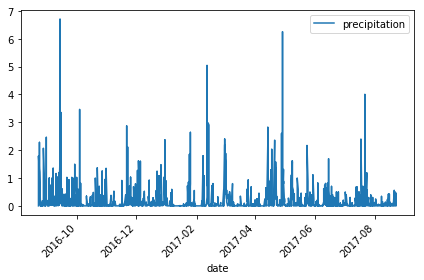

In [144]:
yearOfPrecipDF.plot()
plt.xticks(rotation=45)
plt.tight_layout()

In [39]:
# Use Pandas to calculate the summary statistics for the precipitation data
yearOfPrecipDF.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [89]:
# How many stations are available in this dataset?

stationCount = (session.query(Stations.station).group_by(Stations.station).count())
# equivalently:
# stationCount = session.query(func.count(Stations.station)).all()[0][0]

print(f'there are {stationCount} stations')


there are 9 stations


In [109]:
# What are the most active stations?
# List the stations and the counts in descending order.

stationActivity = (session
    .query(Measurements.station, func.count(Measurements.prcp))
    .group_by(Measurements.station)
    .order_by(func.count(Measurements.prcp).desc())
    )
results = session.execute(stationActivity).fetchall()
stationActivityDF = pd.DataFrame(results, columns = ['station', 'measurement_count'])

stationActivityDF.head(10)


,station,measurement_count
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [124]:
# Using the station id from the previous query, calculate the lowest temperature recorded
# highest temperature recourded, and averge temperature most active station

maxTemp = (session
    .query(Measurements.station, func.max(Measurements.tobs))
    .group_by(Measurements.station)
    .filter(Measurements.station == "USC00519281")
    )

minTemp = (session
    .query(Measurements.station, func.min(Measurements.tobs))
    .group_by(Measurements.station)
    .filter(Measurements.station == "USC00519281")
    )

avgTemp = (session
    .query(Measurements.station, func.avg(Measurements.tobs))
    .group_by(Measurements.station)
    .filter(Measurements.station == "USC00519281")
    )

results = session.execute(maxTemp).fetchall()
print(f"Maximum temperature of station {results[0][0]} = {results[0][1]}")

results = session.execute(minTemp).fetchall()
print(f"Minimum temperature of station {results[0][0]} = {results[0][1]}")

results = session.execute(avgTemp).fetchall()
print(f"Average temperature of station {results[0][0]} = {results[0][1]}")
# print(results)

Maximum temperature of station USC00519281 = 85
Minimum temperature of station USC00519281 = 54
Average temperature of station USC00519281 = 71.66378066378067


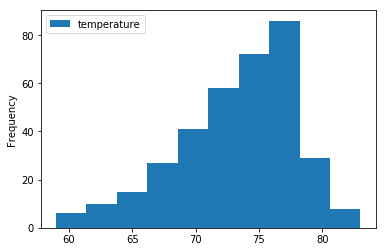

In [137]:
# Choose the station with the highest number of temperature observations
# Query the last 12 months of temperature observation data for this station
lastYear = (session
           .query(Measurements.tobs)
           .filter(Measurements.station == "USC00519281")
           .filter(Measurements.date >= yearAgo)
           .filter(Measurements.date <= latestDate)
           )

results = session.execute(lastYear).fetchall()

lastYearDF = pd.DataFrame(results, columns = ['temperature'])

# lastYearDF.head(20)

lastYearDF.plot(kind='hist')

In [ ]:
# Set default formatting
style.use('fivethirtyeight')

sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot(yearOfPrecipDF.date, yearOfPrecipDF.prcp)
# plt.scatter(yearOfPrecipDF.date, yearOfPrecipDF.prcp)

# yearOfPrecipDF.plot(kind='scatter', x='date', y='prcp')
ymin = 0
ylim = 7
# xmin = startDate
# xlim = endDate

# horLines = np.arange(ymin,ylim, 1)
# verLines = np.arange(xmin,xlim+20, 50)

# sns.lmplot(x = 'date', y = 'prcp',  data=yearOfPrecipDF, fit_reg=False)
fig.autofmt_xdate()

## STILL NEED TO PRINT OUT FIGURE

In [47]:
yearOfPrecipDF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [70]:
stationCount = (session.query(Stations.station).count())

print(stationCount)

# StationDF = pd.DataFrame(stationList)
# yearOfPrecipDF = yearOfPrecipDF.set_index('date')

# StationDF.sort_values(by = 'date')
# StationDF.head()

9


In [ ]:
# stationMeasure = (session.query(Measurement.station))
stationMeasurements = (session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station))
result = session.execute(stationMeasurements).fetchall()
# stationNames = 

stationMeasurementsDF = pd.DataFrame(result)
stationMeasurementsDF.columns = ['station', 'measurements']
# stationMeasurementsDF=stationMeasurementsDF.sort_values('measurements', ascending = False)
# print()
stationMeasurementsDF = pd.merge(stationMeasurementsDF, stationsDF, on="station")



stationMeasurementsDF.head(10)

In [ ]:
# Most observations

# mostObservations = max(stationMeasurementsDF['measurements'])
# mostObservations

maxStation = stationMeasurementsDF.iloc[0]['name']
maxMeasurements = stationMeasurementsDF.iloc[0]['measurements']

print(f'Station {maxStation} made the most measurements:   {maxMeasurements}')


In [ ]:
# Plot observation count as histogram w/ bins = 12
x_axis = np.arange(len(stationMeasurementsDF))
plt.bar(x_axis, stationMeasurementsDF['measurements'])
plt.xticks(x_axis, stationMeasurementsDF['name'])
# fig, axes = plt.subplots(2, 2, figsize=(15, 8), dpi=200)
fig, ax = plt.subplots()

# ax = axes.flatten[0]
ax.plot(data.index, data['value'])
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.setp(stationMeasurementsDF['name'].get_xticklabels(), rotation=30, horizontalalignment='right')
plot(xrange(9))
yticks(xrange(9), rotation='vertical')


# fig.autofmt_xdate()

# x_axis
# y_values

In [ ]:
def mask(df, key, value):
     return df[df[key] == value]

    
    
# measurementsDF = mask(measurementsDF, 'name', 'USC00511918')
measurementsDF = measurementsDF[(measurementsDF['station'] == 'USC00511918')]


plt.hist(measurementsDF['prcp'], normed=True, bins=30)


In [ ]:
# Write a function called 'calc_temps' that will accept a start datae and end date
# in the format '%Y-%m-%d' and return the minimum, average, and maximum temperature for
# that range of dates


In [ ]:
# Use the 'calc_temps' function to calculate the min, avg, and max temperatures for your
# trip using the matching dates from the previous year (i.e. use "2017-01-01" if your
# start date was "2018-01-01")

In [ ]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [ ]:
# design a Flask API based on the queries that you have just developed.
# Use FLASK to create your routes.

In [ ]:
# 